In [1]:
import simulation_model as sim

In [10]:
capacity_initial = {'housing' : 40, 'shelter' : 15}
housing_build_frequency = 63/365 # in years
end_of_simulation = 6 # in years
service_mean = {'housing' : (1/52)*(0+300+400)/3, 'shelter' : 0.0} # in years
arrival_rates = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100, 37.4052] # expected number per year
build_rate_change_frequency = 1 # in years
# build_rates = {'housing' : [3,6,7,10,8,4], 'shelter' : [2,2,0,-2,-1,-1]}
build_rates = {'housing' : [18, 36, 42, 60, 48, 24], 'shelter' : [12, 12, 0, -12, -6, -6]}
current_demand = 120
number_reps = 100
seed = 10

In [11]:
output = sim.simulate(end_of_simulation, 
                      number_reps, 
                      housing_build_frequency, 
                      build_rate_change_frequency, 
                      capacity_initial, 
                      service_mean, 
                      arrival_rates, 
                      build_rates, 
                      current_demand, 
                      seed)

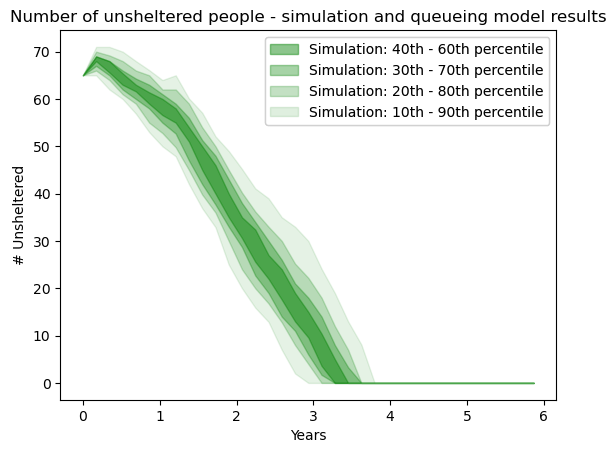

In [12]:
fig, ax = sim.create_fanchart(output)